### Importing Required Libraries

This cell imports all the essential libraries needed for:

- **Data Handling & File Operations**  
  - `NumPy`, `Pandas`, `OS` for efficient data manipulation and managing files.

- **Deep Learning Model Building & Training**  
  - `TensorFlow` / `Keras` modules to create layers, build models, and handle training utilities.

- **Data Visualization**  
  - `Matplotlib` and `Seaborn` for insightful plotting and visual representation of results.

- **Warning Management**  
  - `Warnings` to suppress unnecessary or distracting warning messages for a cleaner output.

This setup ensures smooth data preprocessing, model creation, and analysis workflows in your project.


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2025-08-11 14:04:28.922091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754921069.298178      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754921069.406873      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading Image Paths and Captions Data

- **`image_path`** stores the directory path where the Flickr8k images are located.
- **`data`** reads the captions dataset (`captions.txt`) into a Pandas DataFrame for easy manipulation.
- The `.head()` function previews the first few rows to quickly inspect the loaded data.


In [26]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

### Image Reading and Display Functions

- **`readImage(path, img_size=299)`**  
  Loads an image from the given `path`, resizes it to a square of `img_size` (default 299x299), converts it to a NumPy array, and normalizes pixel values to the [0, 1] range for model readiness.

- **`display_images(temp_df)`**  
  Visualizes a sample of images alongside their captions from a DataFrame:  
  - Resets the DataFrame index for clean iteration.  
  - Creates a 20x20 inch figure to fit multiple images.  
  - Loops through 15 randomly chosen entries, displaying each image with its wrapped caption as the subplot title.  
  - Turns off axes for a cleaner look.

- **Usage**  
  Calling `display_images(data.sample(15))` shows 15 random images with captions from the dataset — a quick sanity check and a nice visual teaser of your data!

This combo helps you peek into your dataset visually, ensuring images and captions align perfectly before diving into training.


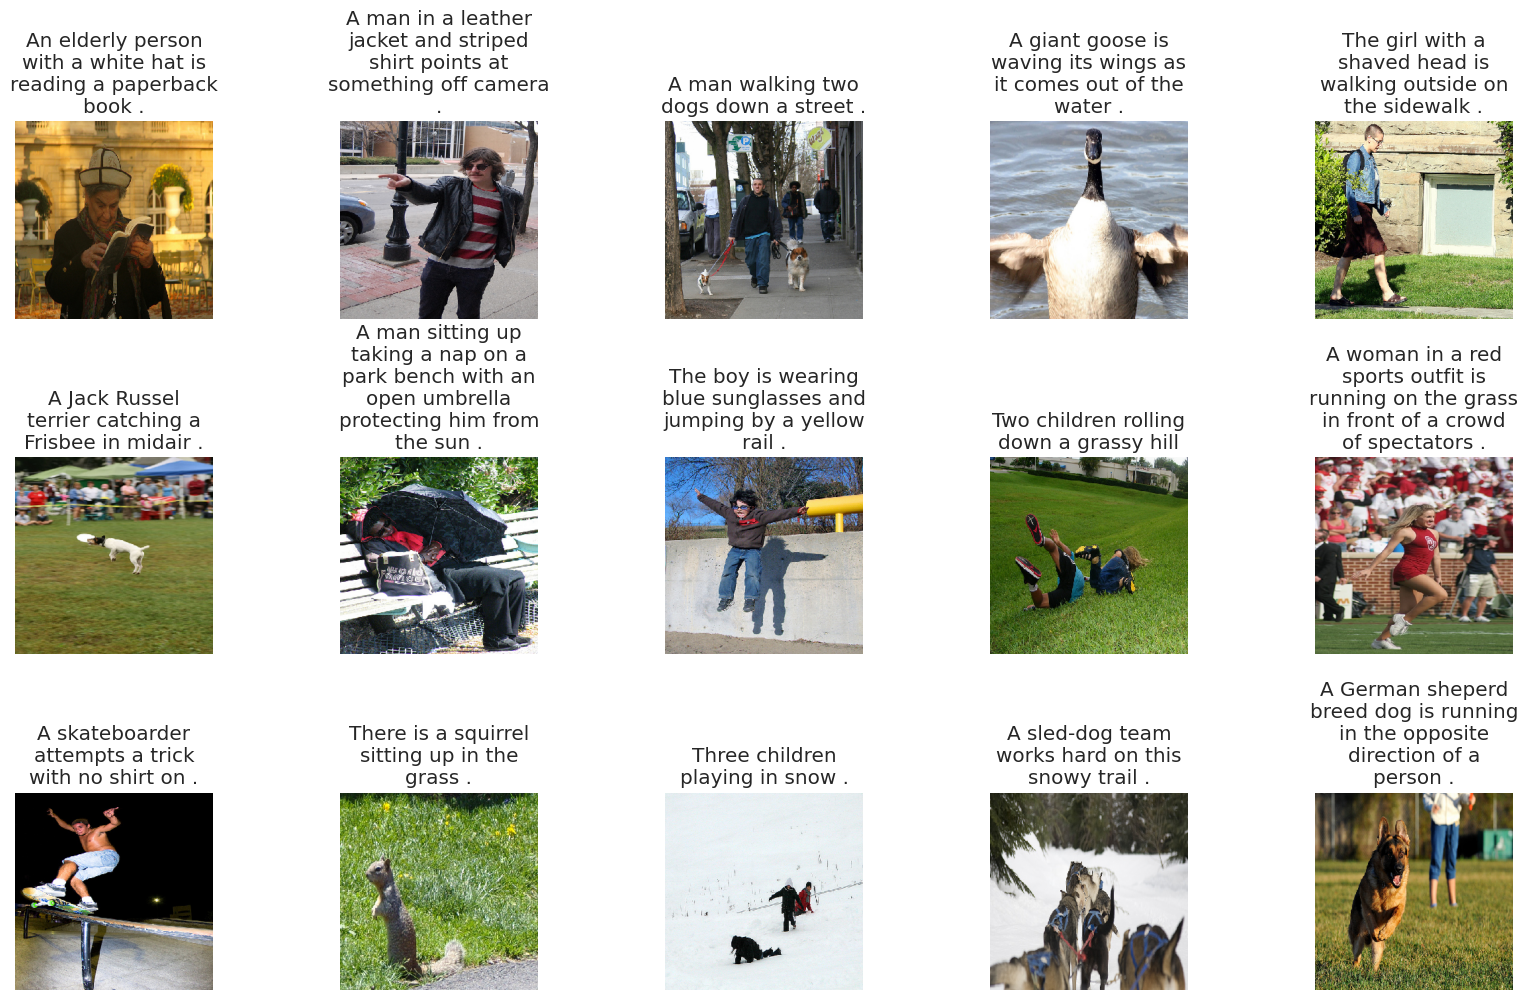

In [27]:
def readImage(path,img_size=299):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

### Text Preprocessing for Captions

The `text_preprocessing` function performs several crucial steps to clean and prepare the captions for modeling:

- Converts all text to lowercase to maintain consistency.
- Removes any characters that are **not alphabets** using a regex pattern (`[^A-Za-z]`) — strips out numbers, punctuation, and symbols.
- Collapses multiple spaces into a single space to tidy up spacing.
- Removes any words with length less than or equal to 1 (removes stray letters or noise).
- Adds special tokens `"startseq"` at the beginning and `"endseq"` at the end of each caption to mark sentence boundaries, which is helpful for sequence models.

Finally, it returns the cleaned DataFrame with updated captions.

After processing, the cleaned captions are extracted into a list with `captions = data['caption'].tolist()`, and the first 10 are displayed for a quick sanity check.


In [28]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data 
    
data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Tokenization and Dataset Splitting

- **Tokenizer Initialization & Vocabulary Building**  
  - Instantiates a Keras `Tokenizer` and fits it on the cleaned captions, converting words to unique integer indices.  
  - Calculates `vocab_size` to know the total number of unique tokens plus one (for padding).  
  - Finds `max_length` to determine the longest caption sequence length, essential for padding inputs consistently.

- **Image List and Train-Test Split**  
  - Extracts unique image filenames from the dataset.  
  - Splits images into training and validation sets with an 85-15 ratio to ensure no data leakage between splits.  
  - Filters captions based on these splits, assigning corresponding rows to `train` and `test` DataFrames.  
  - Resets indices for clean, contiguous DataFrames.

- **Sanity Check**  
  - Converts a sample caption (`captions[1]`) into its tokenized integer sequence to verify the tokenizer’s functionality.

This systematic approach ensures the model trains on unseen images during validation, providing reliable performance estimates and a clean input pipeline for sequence modeling.


In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

### Feature Extraction Using InceptionV3

This section harnesses the power of the pre-trained **InceptionV3** model to extract meaningful features from images, which will later feed into our captioning model.

- **Model Setup:**  
  - Loads the InceptionV3 model pre-trained on ImageNet **without the final classification layer** to get raw image embeddings (features).  
  - Defines a new feature extractor model (`fe`) that outputs the penultimate layer's activations — effectively a high-level representation of the image.

- **Image Preprocessing & Feature Extraction:**  
  - Iterates through each unique image in the dataset.  
  - Loads and resizes images to the required 299x299 input size.  
  - Converts images to arrays and expands dimensions to fit model input shape.  
  - Applies InceptionV3-specific preprocessing (scaling, normalization, etc.).  
  - Passes the processed image through the feature extractor model to obtain feature vectors.  
  - Stores features in a dictionary with image filenames as keys for quick lookup.

- **Persistence:**  
  - Saves the extracted feature dictionary to a `features.pkl` file using `pickle`, ensuring the heavy lifting is done once and can be reused for efficient training.

This modular approach supercharges our image captioning pipeline by turning images into rich, compact vectors that models love to consume — all while saving time and computational resources in the long run!


In [30]:
# ====================== FEATURE EXTRACTION USING INCEPTIONV3 ======================

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from tqdm import tqdm
import pickle

# Load InceptionV3 without the top classification layer
base_model = InceptionV3(weights='imagenet')
fe = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

img_size = 299
features = {}

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # InceptionV3 preprocessing
    feature = fe.predict(img, verbose=0)
    features[image] = feature[0]

# Save extracted features
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)


100%|██████████| 8091/8091 [13:07<00:00, 10.27it/s]


### Custom Data Generator for Image Captioning

This `CustomDataGenerator` class is a specialized Keras `Sequence` designed to efficiently feed data into the model during training, handling both images and captions in sync.

- **Initialization (`__init__`):**  
  Sets up the generator with:  
  - The DataFrame containing image-caption pairs (`df`).  
  - Column names for images (`X_col`) and captions (`y_col`).  
  - Batch size, image directory path, tokenizer, vocabulary size, maximum caption length, and pre-extracted image features.  
  - A shuffle option to randomize data order after each epoch for better generalization.

- **Epoch End Handling (`on_epoch_end`):**  
  Shuffles the dataset at the end of each epoch if `shuffle=True`, preventing model overfitting by presenting data in a different order every time.

- **Batch Count (`__len__`):**  
  Returns the total number of batches per epoch based on dataset size and batch size.

- **Batch Data Retrieval (`__getitem__`):**  
  Fetches a batch of data by index and returns inputs and targets in the format the model expects.

- **Data Preparation (`__get_data__`):**  
  For each image in the batch:  
  - Retrieves its pre-extracted feature vector.  
  - Finds all captions linked to that image.  
  - Tokenizes each caption into sequences.  
  - Generates multiple input-output pairs from each caption to train the model on predicting the next word given previous words and the image context.  
  - Pads input sequences to `max_length` and one-hot encodes output words for categorical cross-entropy loss.  
  - Collects image features, input sequences, and output words into NumPy arrays for efficient batch processing.

- **Usage:**  
  Instantiates `train_generator` and `validation_generator` for feeding training and validation data into the model seamlessly.

---

Feel like this deserves a gif of a conveyor belt delivering hot data? Because that’s what it is—smooth, reliable, and oh-so-efficient! Need me to help you add progress bars, debug hooks, or more comments in the code?


In [31]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [32]:
train_generator[0]

((array([[0.12277611, 0.33293045, 0.7527239 , ..., 0.21941449, 0.30208504,
          0.40279686],
         [0.12277611, 0.33293045, 0.7527239 , ..., 0.21941449, 0.30208504,
          0.40279686],
         [0.12277611, 0.33293045, 0.7527239 , ..., 0.21941449, 0.30208504,
          0.40279686],
         ...,
         [0.13507597, 0.1565125 , 0.6852764 , ..., 0.6462806 , 0.21949847,
          0.3609016 ],
         [0.13507597, 0.1565125 , 0.6852764 , ..., 0.6462806 , 0.21949847,
          0.3609016 ],
         [0.13507597, 0.1565125 , 0.6852764 , ..., 0.6462806 , 0.21949847,
          0.3609016 ]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,  49,   4, 210]], dtype=int32)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.

### Building and Training the Image Captioning Model

#### Model Architecture

- **Inputs:**  
  - `input1`: Image feature vectors of shape `(2048,)` extracted from InceptionV3.  
  - `input2`: Tokenized caption sequences of variable length (`max_length`).

- **Image Feature Processing:**  
  - Dense layer with 256 units and ReLU activation reduces dimensionality and extracts salient information.  
  - Reshaped to `(1, 256)` to prep for sequence concatenation.

- **Caption Feature Processing:**  
  - Embedding layer transforms integer tokens into 256-dimensional dense vectors.  
  - Combined (concatenated) with image features along the time axis to form a joint sequence.

- **Sequence Modeling:**  
  - LSTM with 256 units processes the combined sequence, capturing context from both image and partial caption.  
  - Dropout layers with 0.5 rate add regularization to prevent overfitting.

- **Fusion and Output:**  
  - Residual connection via `add` merges LSTM output and image features for richer representation.  
  - Dense layers refine features and output a probability distribution over the vocabulary with a softmax activation.

- **Compilation:**  
  - Loss: Categorical crossentropy, ideal for multi-class word prediction.  
  - Optimizer: Adam, a reliable workhorse for fast convergence.

---

#### Training Callbacks

- **ModelCheckpoint:**  
  Saves the best model based on validation loss, so you never lose your MVP.

- **EarlyStopping:**  
  Stops training if validation loss doesn't improve for 5 consecutive epochs, preventing wasted cycles.

- **ReduceLROnPlateau:**  
  Dynamically lowers learning rate by a factor of 0.2 if the validation loss plateaus for 3 epochs — perfect for fine-tuning.

---

#### Training Execution

- Runs for up to 50 epochs, using the custom data generators for efficient batch feeding.  
- Validates performance on the hold-out set (`validation_generator`).  
- Monitors loss metrics and triggers callbacks to optimize training flow.

---

This setup combines cutting-edge sequence modeling with powerful image features and smart training heuristics — a recipe for a model that learns not just to see, but to *describe* like a pro storyteller.

---

Ready to watch those loss curves dive and BLEU scores soar? 🚀 Need help visualizing training history or tweaking hyperparameters? Just say the word!


In [33]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 5.7243
Epoch 1: val_loss improved from inf to 4.33149, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 143ms/step - loss: 5.7231 - val_loss: 4.3315 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.3784
Epoch 2: val_loss improved from 4.33149 to 4.00757, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - loss: 4.3782 - val_loss: 4.0076 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 4.0598
Epoch 3: val_loss improved from 4.00757 to 3.84375, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - loss: 4.0597 - val_loss: 3.8437 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 3.8560
Epoch 4: val_loss improved from 3.84375 to 3.74453, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 139ms/step - loss: 3.8560 - val_loss: 3.7445 - learning_rate: 0.0010


### Training Loss Visualization

This plot tracks the model’s **training** and **validation loss** across epochs:

- The **blue line** shows the loss on the training data — ideally, it should decrease steadily as the model learns.
- The **orange line** tracks validation loss — a key indicator of how well the model generalizes to unseen data.
- Close alignment between these lines suggests healthy learning without overfitting.
- If the validation loss starts rising while training loss keeps dropping, it’s a sign of overfitting and might call for more regularization or early stopping.

By visualizing these trends, you get a real-time pulse on your model’s learning journey and can make informed decisions on tweaks or early stopping.

---




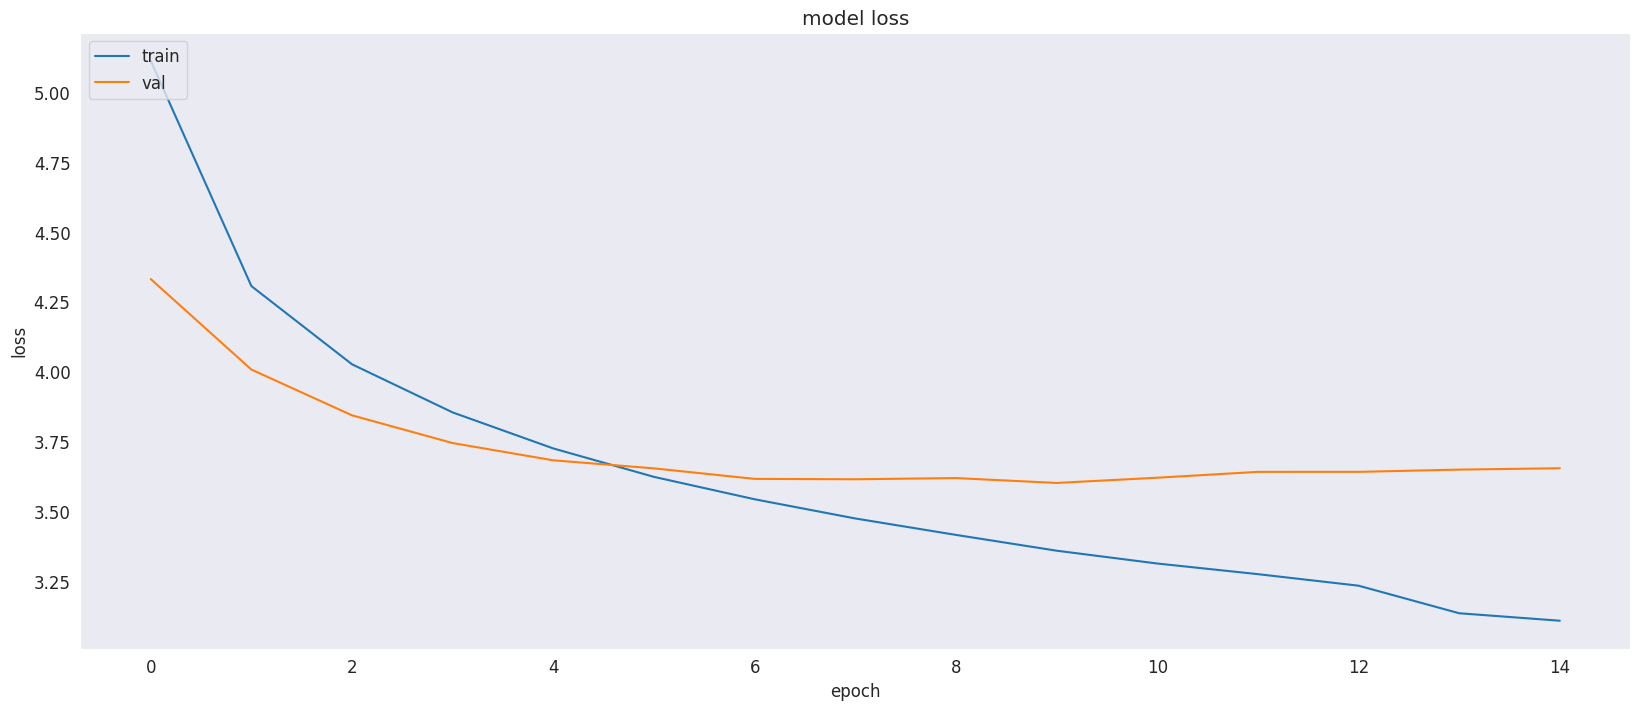

In [34]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

### Caption Generation and Visualization Function

This function `generate_and_display_caption` takes an image path and uses the trained model pipeline to generate a descriptive caption:

- **Model & Tokenizer Loading:**  
  Loads the saved captioning model, feature extractor, and tokenizer objects from disk.

- **Image Preprocessing:**  
  Loads the input image, resizes it to the model's expected input size (`299x299`), normalizes pixel values, and prepares it for feature extraction.

- **Feature Extraction:**  
  Uses the pre-trained feature extractor to get a rich, compact representation of the image.

- **Caption Generation Loop:**  
  - Starts with the special token `"startseq"`.  
  - Iteratively predicts the next word by feeding the current partial caption and image features into the model.  
  - Decodes the predicted word index back into a word using the tokenizer's dictionary.  
  - Stops when `"endseq"` token is predicted or max caption length is reached.  
  - Builds the caption word-by-word, mimicking human sentence construction.

- **Visualization:**  
  Displays the input image alongside the AI-generated caption in a visually appealing plot with the caption styled in blue for a splash of personality.

---




In [37]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=299):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

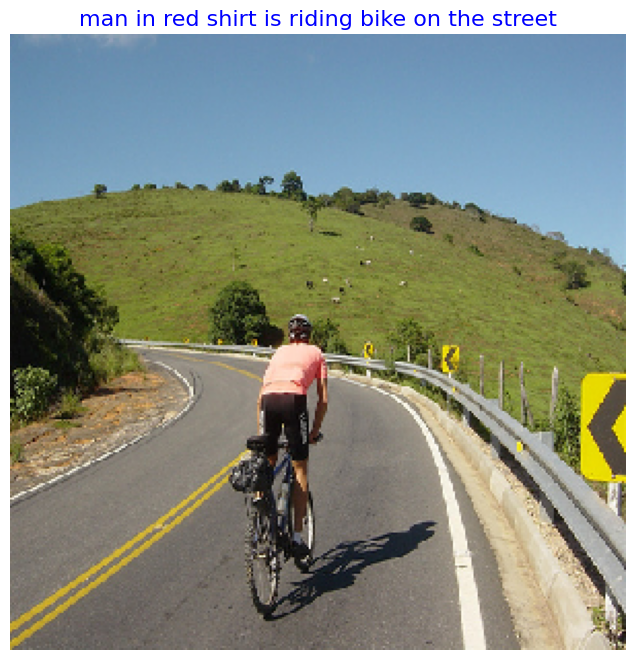

In [38]:
# Example usage
image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

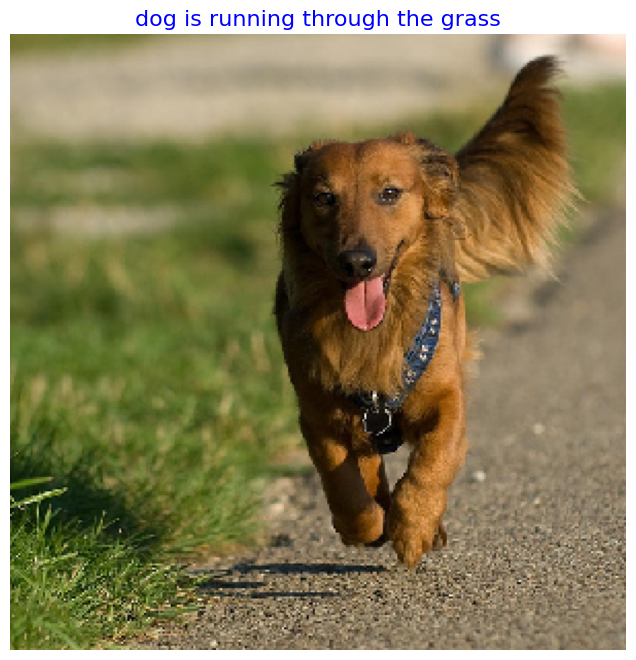

In [39]:
image_path = "/kaggle/input/flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

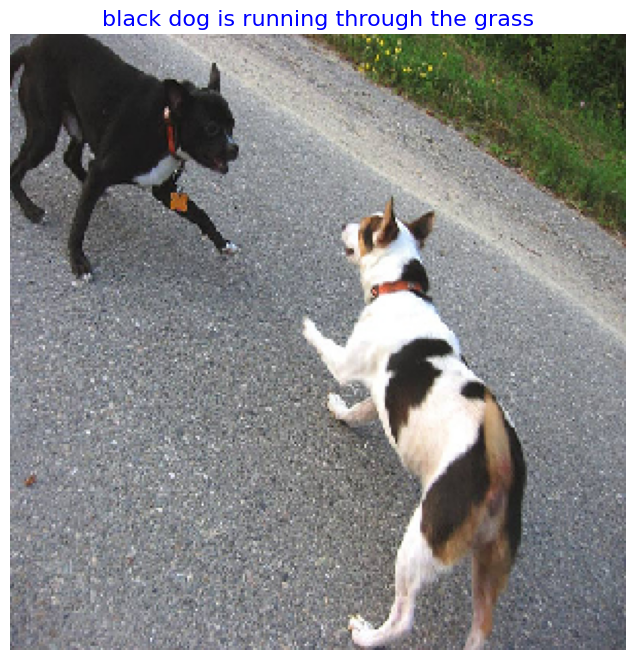

In [40]:
image_path = "/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

### Evaluating Caption Quality with BLEU Scores

This block evaluates how well the model-generated captions match the ground-truth captions in the test set using BLEU (Bilingual Evaluation Understudy) metrics:

- **Model & Tokenizer Loading:**  
  Loads the trained captioning model, feature extractor, and tokenizer once to speed up evaluation.

- **Caption Generation (`generate_caption_only`):**  
  For each test image:  
  - Loads and preprocesses the image.  
  - Extracts image features.  
  - Iteratively predicts words until the `"endseq"` token or maximum caption length is reached.  
  - Produces a clean caption without start/end tokens.

- **Data Preparation for BLEU:**  
  - Collects generated captions and corresponding reference captions (ground truth) from the test set.  
  - Cleans captions by removing special tokens and lowercasing for fair comparison.  
  - Tokenizes captions into word lists for BLEU calculation.

- **BLEU Scores Computed:**  
  - **BLEU-1:** Measures overlap of unigrams (individual words).  
  - **BLEU-2:** Considers bigram (pairs of words) matching.  
  - **BLEU-3 & BLEU-4:** Look at longer sequences of 3 and 4 words, assessing fluency and context accuracy.

- **Interpretation:**  
  Higher BLEU scores imply better alignment between generated captions and references, indicating more accurate and natural language generation.

---



In [68]:
import os
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Paths (update if needed)
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"
image_path = "/kaggle/input/flickr8k/Images"

max_length = 34  # same max_length you used in training

# Load models and tokenizer once (to save time)
caption_model = load_model(model_path)
feature_extractor = load_model(feature_extractor_path)
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

def generate_caption_only(img_path):
    img = load_img(img_path, target_size=(299, 299))  # corrected image size
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)
    
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None or word == "endseq":
            break
        in_text += " " + word

    caption = in_text.replace("startseq", "").strip()
    return caption

# Collect test image names from your 'test' dataframe
test_images = test['image'].unique().tolist()

generated_captions = []
reference_captions = []

for img_name in tqdm(test_images, desc="Generating captions"):
    img_path = os.path.join(image_path, img_name)
    gen_caption = generate_caption_only(img_path)
    generated_captions.append(gen_caption)
    
    refs = test[test['image'] == img_name]['caption'].tolist()
    refs = [ref.replace("startseq", "").replace("endseq", "").strip() for ref in refs]
    reference_captions.append(refs)

# Tokenize for BLEU
gen_tokens = [cap.lower().split() for cap in generated_captions]
ref_tokens = [[ref.lower().split() for ref in refs] for refs in reference_captions]

# Calculate BLEU scores
bleu1 = corpus_bleu(ref_tokens, gen_tokens, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(ref_tokens, gen_tokens, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(ref_tokens, gen_tokens, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(ref_tokens, gen_tokens, weights=(0.25, 0.25, 0.25, 0.25))

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")


Generating captions: 100%|██████████| 1214/1214 [17:07<00:00,  1.18it/s]


BLEU-1: 0.5079
BLEU-2: 0.3093
BLEU-3: 0.1815
BLEU-4: 0.0975


##  Data Analytics & Exploratory Data Analysis (EDA)

Starting from this point, we dive into **data analytics** to extract insights, understand patterns, and identify trends in our image-caption dataset.




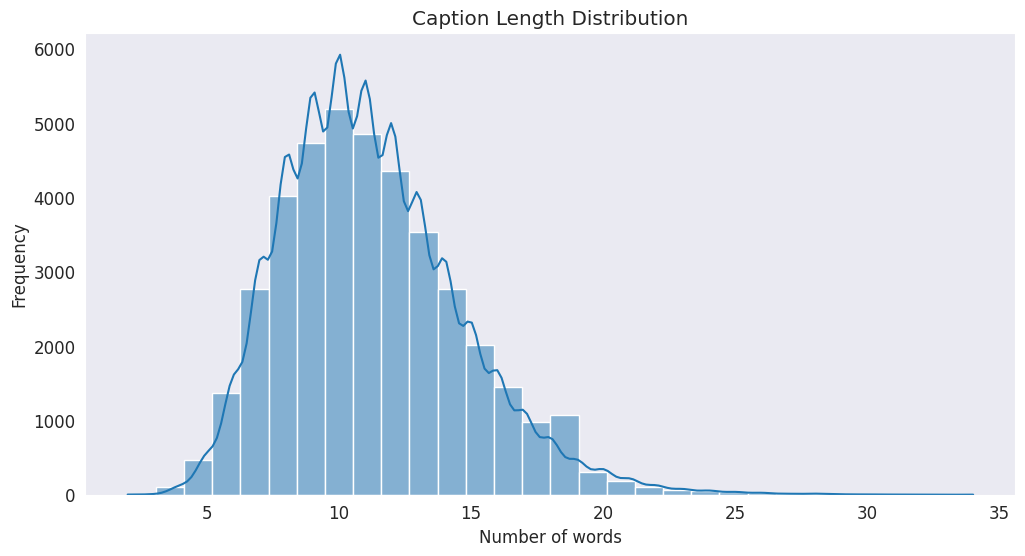

In [69]:
caption_lengths = data['caption'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.histplot(caption_lengths, bins=30, kde=True)
plt.title('Caption Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()


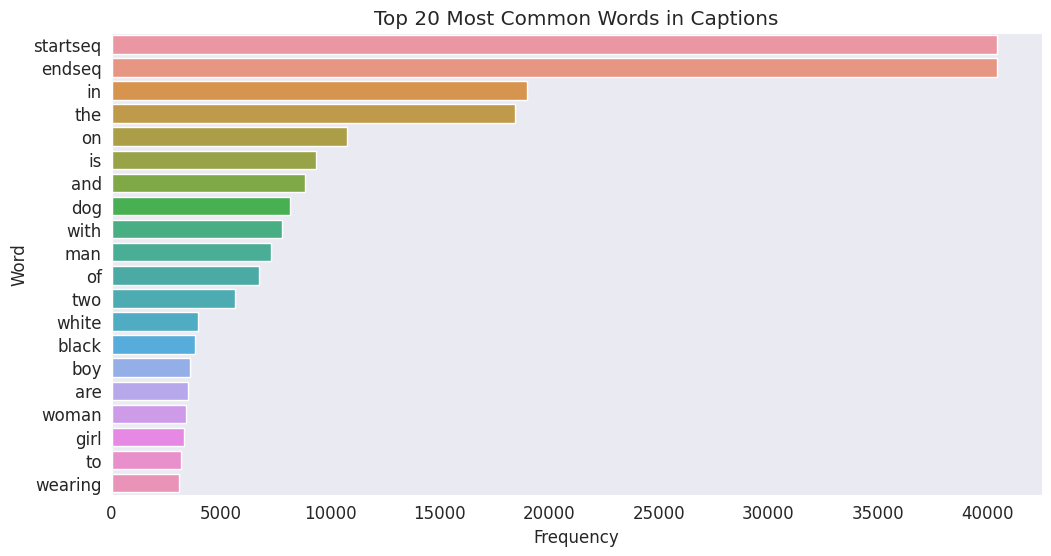

In [70]:
from collections import Counter
all_words = ' '.join(data['caption']).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Common Words in Captions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


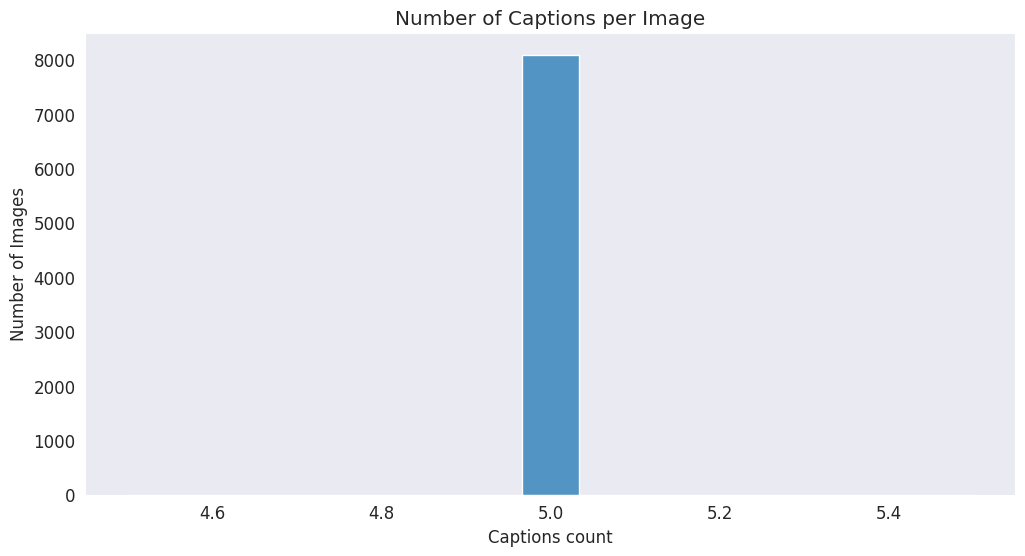

In [71]:
captions_per_image = data.groupby('image').size()
plt.figure(figsize=(12,6))
sns.histplot(captions_per_image, bins=15, kde=False)
plt.title('Number of Captions per Image')
plt.xlabel('Captions count')
plt.ylabel('Number of Images')
plt.show()


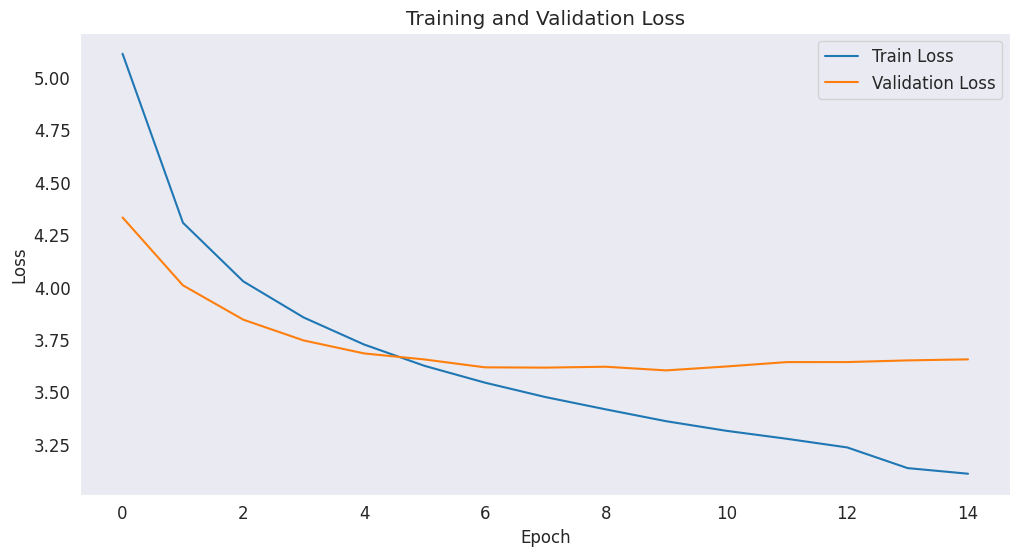

In [72]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


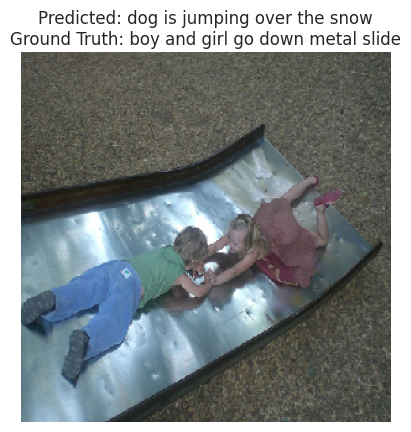

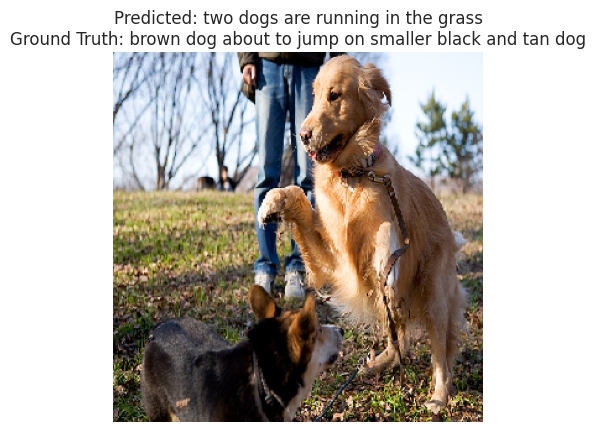

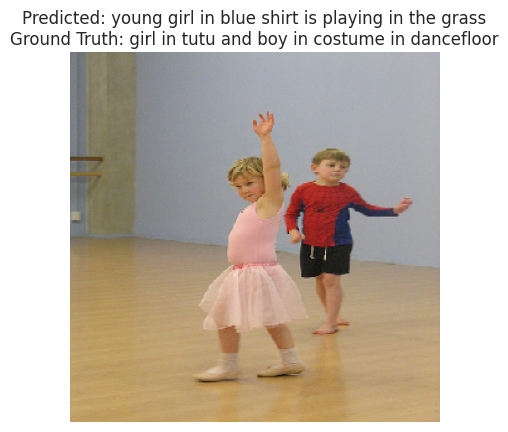

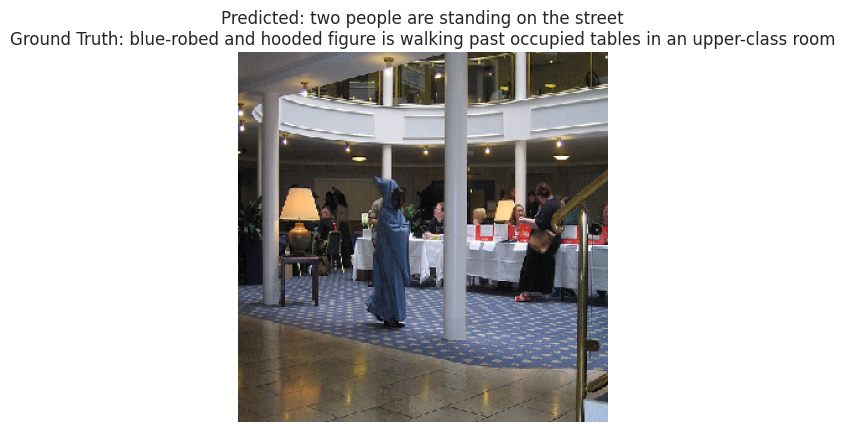

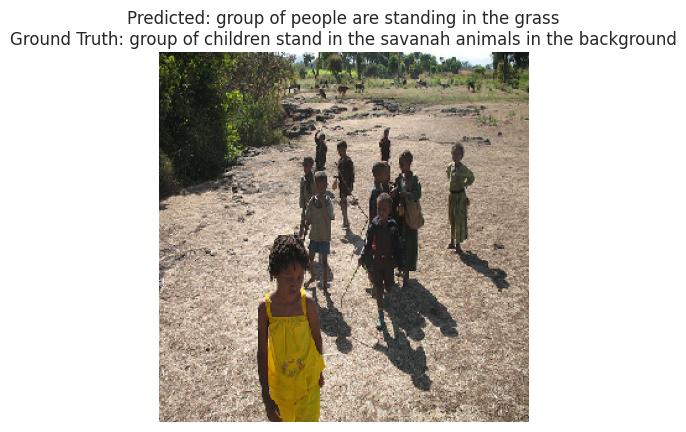

In [73]:
import random

sample_images = random.sample(test_images, 5)

for img_name in sample_images:
    img_path = os.path.join(image_path, img_name)
    pred_caption = generate_caption_only(img_path)
    refs = test[test['image'] == img_name]['caption'].tolist()
    refs = [ref.replace("startseq", "").replace("endseq", "").strip() for ref in refs]

    img = load_img(img_path, target_size=(299, 299))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_caption}\nGround Truth: {refs[0]}", fontsize=12)
    plt.show()


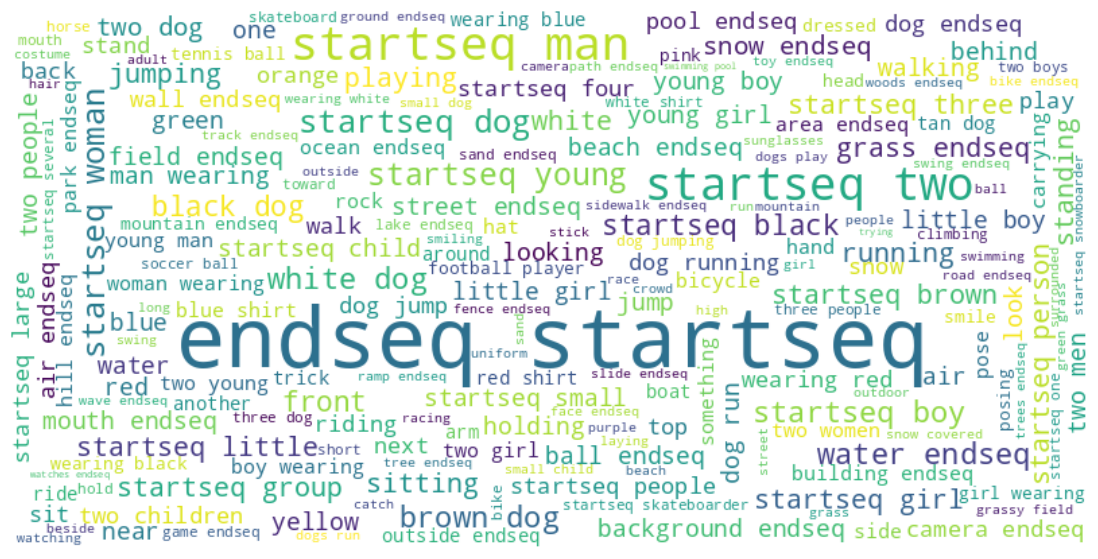

In [74]:
from wordcloud import WordCloud

text = ' '.join(data['caption'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# 🖼️ Image Captioning with Streamlit

This notebook demonstrates an AI-powered image caption generator using a pretrained deep learning model.

### How to Run This Code on Kaggle:

1. **Upload your pretrained models and tokenizer files** to the Kaggle notebook environment, e.g., `model.keras`, `feature_extractor.keras`, and `tokenizer.pkl`.  
   You can do this by clicking on the "Add data" button on the right sidebar and uploading these files or linking a Kaggle dataset.

2. **Run all the cells** in this notebook. The Streamlit app will launch as a web app inside Kaggle’s system.

3. **Interact with the Streamlit UI** to upload an image (`jpg`, `jpeg`, or `png`) and generate captions.

---

### Notes:
- The feature extractor expects images resized to 299x299 pixels (InceptionV3 input size).
- The caption generation starts with a `startseq` token and ends at `endseq`.
- Adjust `MAX_LENGTH` if your trained model uses a different max caption length.

---

### How to launch the Streamlit app (optional):

If you want to run the Streamlit app locally, save this script as `app.py` and run:

```bash
streamlit run app.py


In [ ]:
'''
import streamlit as st
import tensorflow as tf
import pickle
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----------------------------------------
# Load models and tokenizer (cached for performance)
# ----------------------------------------
@st.cache_resource
def load_models():
    # Update paths below to match Kaggle dataset or uploaded file locations
    model = load_model("/kaggle/input/your-dataset/model.keras")
    feature_extractor = load_model("/kaggle/input/your-dataset/feature_extractor.keras")
    with open("/kaggle/input/your-dataset/tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    return model, feature_extractor, tokenizer

model, feature_extractor, tokenizer = load_models()

# ----------------------------------------
# Parameters from your training process
# ----------------------------------------
MAX_LENGTH = 34  # change if your model used a different max caption length

# ----------------------------------------
# Helper Functions
# ----------------------------------------
def extract_features(image):
    # Resize to expected input size for the feature extractor (InceptionV3)
    image = image.resize((299, 299))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    # Extract features using the pretrained feature extractor model
    return feature_extractor.predict(image, verbose=0)

def idx_to_word(integer):
    # Map predicted index back to word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(photo):
    # Generate caption word-by-word
    in_text = 'startseq'
    for _ in range(MAX_LENGTH):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=MAX_LENGTH)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    # Clean up caption before returning
    return in_text.replace('startseq', '').replace('endseq', '').strip()

# ----------------------------------------
# Streamlit User Interface
# ----------------------------------------
st.set_page_config(page_title="Image Captioning", page_icon="🖼️", layout="centered")
st.title("🖼️ Image Caption Generator")
st.write("Upload an image and get an AI-generated caption.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    if st.button("Generate Caption"):
        photo_features = extract_features(image)
        caption = generate_caption(photo_features)
        st.success(f"**Caption:** {caption}")
'''
